In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marmara-region-earthquakes-apr-2324-2025/deprem_son24saat_duzenli.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb

In [3]:
df=pd.read_csv('/kaggle/input/marmara-region-earthquakes-apr-2324-2025/deprem_son24saat_duzenli.csv')
df["Olus_Zamani"] = pd.to_datetime(df["Olus_Zamani"])
df["Saat"] = df["Olus_Zamani"].dt.hour
df["Gun"] = df["Olus_Zamani"].dt.day
df["Dakika"] = df["Olus_Zamani"].dt.minute

In [4]:
le=LabelEncoder()
df['Yer']=le.fit_transform(df['Yer'])

In [5]:
y=df['Buyukluk']
x=df.drop(columns=['Yer','Olus_Zamani'],axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42)

In [7]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

rf = RandomForestRegressor(random_state=42)
xgb_reg = xgb.XGBRegressor(random_state=42)

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, n_iter=10, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42, n_jobs=-1)
xgb_random = RandomizedSearchCV(estimator=xgb_reg, param_distributions=xgb_params, n_iter=10, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [8]:
best_rf = rf_random.best_estimator_
best_xgb = xgb_random.best_estimator_

estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb)
]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

stacking_regressor.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(n_estimators=300,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy...
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=LinearRegression(), n_jobs=-1)

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
models = {
    'Random Forest (Best)': best_rf,
    'XGBoost (Best)': best_xgb,
    'Stacking Regressor': stacking_regressor
}
for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train) 
    
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)

    print(f"*** {name} ***")
    print(f"Train için metrikler: RMSE: {rmse_train:.5f} | R²: {r2_train:.5f}")
    print(f"Test için metrikler : RMSE: {rmse_test:.5f} | R²: {r2_test:.5f}")
    print("-" * 50)

*** Random Forest (Best) ***
Train için metrikler: RMSE: 0.02691 | R²: 0.99858
Test için metrikler : RMSE: 0.06127 | R²: 0.99190
--------------------------------------------------
*** XGBoost (Best) ***
Train için metrikler: RMSE: 0.00015 | R²: 1.00000
Test için metrikler : RMSE: 0.04610 | R²: 0.99541
--------------------------------------------------
*** Stacking Regressor ***
Train için metrikler: RMSE: 0.01154 | R²: 0.99974
Test için metrikler : RMSE: 0.04362 | R²: 0.99589
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


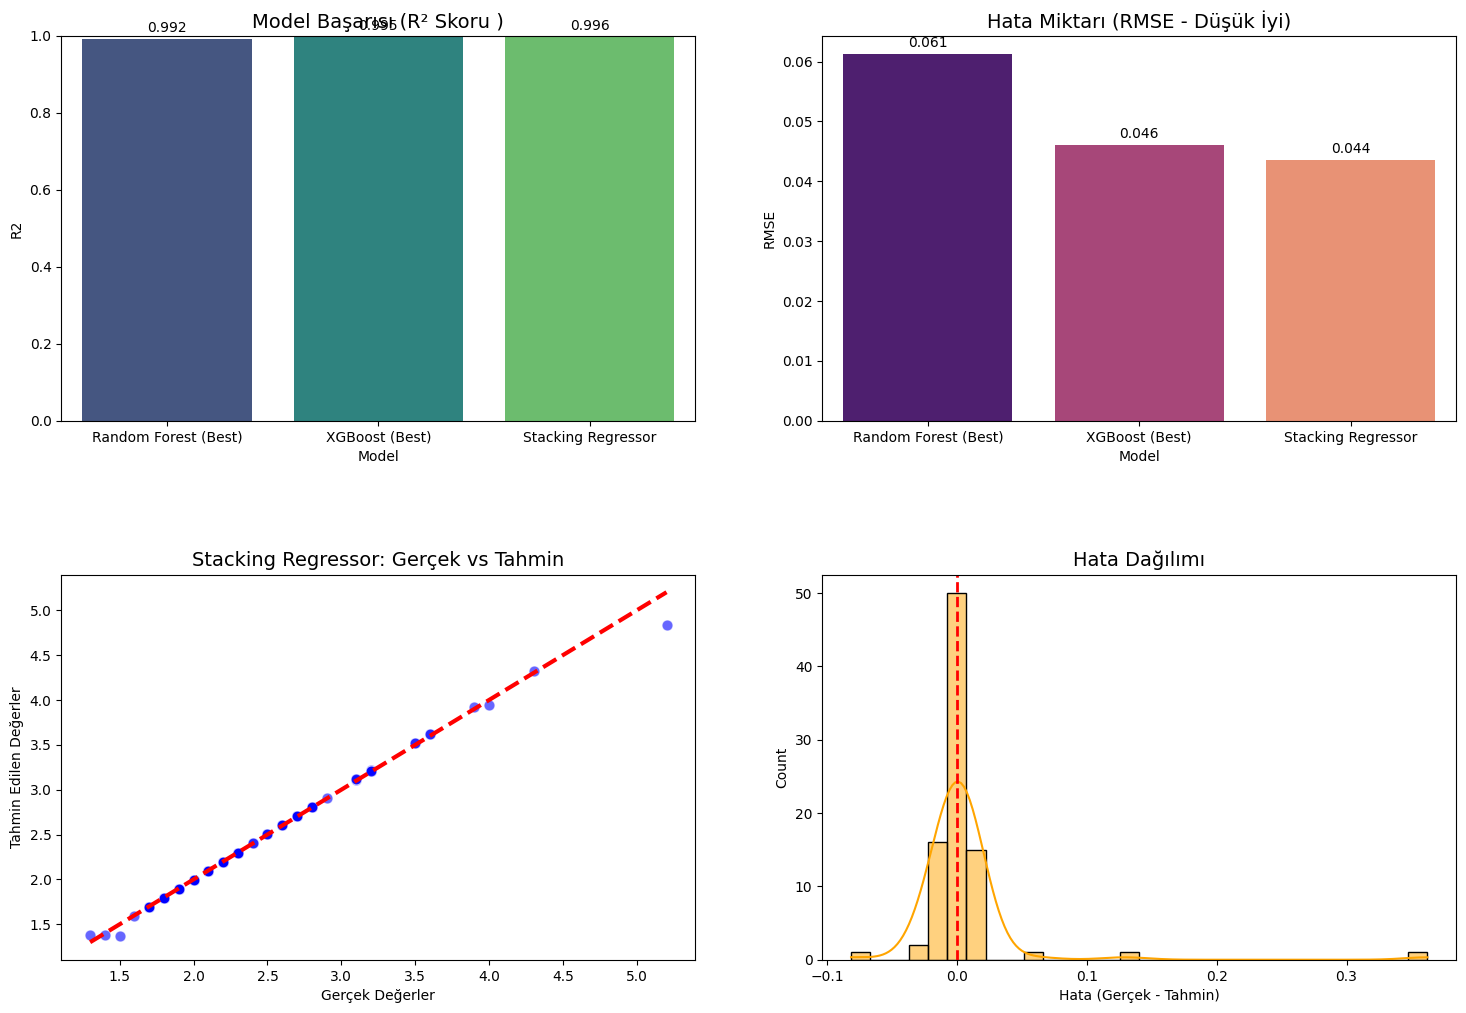

In [10]:
results_data = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results_data.append({'Model': name, 'RMSE': rmse, 'R2': r2})

df_results = pd.DataFrame(results_data)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4)
sns.barplot(x='Model', y='R2', data=df_results, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Model Başarısı (R² Skoru )', fontsize=14)
axes[0, 0].set_ylim(0, 1) 
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%.3f', padding=3)
sns.barplot(x='Model', y='RMSE', data=df_results, ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('Hata Miktarı (RMSE - Düşük İyi)', fontsize=14)
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%.3f', padding=3)

stack_model = models['Stacking Regressor']
y_pred_stack = stack_model.predict(X_test)

sns.scatterplot(x=y_test, y=y_pred_stack, ax=axes[1, 0], color='blue', alpha=0.6, s=60)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
axes[1, 0].set_title('Stacking Regressor: Gerçek vs Tahmin', fontsize=14)
axes[1, 0].set_xlabel('Gerçek Değerler')
axes[1, 0].set_ylabel('Tahmin Edilen Değerler')
residuals = y_test - y_pred_stack
sns.histplot(residuals, kde=True, ax=axes[1, 1], color='orange', bins=30)
axes[1, 1].axvline(0, color='red', linestyle='--', lw=2) 
axes[1, 1].set_title('Hata Dağılımı', fontsize=14)
axes[1, 1].set_xlabel('Hata (Gerçek - Tahmin)')

plt.show()